In [18]:
import os
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from standard import analysis_pn2kc_training
import tools
import sys
import seaborn as sns
from pathlib import Path

from pylab import rcParams
# rcParams['figure.figsize'] = 3, 2
# rcParams['font.size'] = 14
# rcParams['axes.linewidth']=2
rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

FIGSIZE = (1.6, 1.2)
RECT = [0.3, 0.3, 0.65, 0.65]

path = Path(os.getcwd())
project_path = path.parent.absolute()
figure_path = os.path.join(project_path, '_hemibrain', 'figures')
hemibrain_path = os.path.join(project_path, '_hemibrain')
sys.path.append(os.path.dirname(os.getcwd()))

In [19]:
def save_fig(save_path, figname='', dpi=1000, pdf=True, show=True):
    os.makedirs(save_path, exist_ok=True)
    plt.savefig(os.path.join(save_path, figname + '.png'),
                dpi=dpi,
                transparent=True)
    if pdf:
        plt.savefig(os.path.join(save_path, figname + '.pdf'), transparent=True)
    if show:
        plt.show()
    print('Figure saved at: {}'.format(os.path.join(save_path, figname)))
    plt.close()

def pretty_fig(figsize=(3, 2), rect=(0.3, 0.3, 0.5, 0.5), rows=1, cols=1):
    if rows > 1 or cols > 1:
        f, ax = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
        for a in ax:
            plt.sca(a)
            sns.despine()
    else:
        f = plt.figure(figsize=figsize)
        ax = f.add_axes(rect)
    sns.despine()
    return f, ax

def _plot_sparsity(ax,
                   data,
                   xrange=50,
                   yrange=None,
                   text=True,
                   alpha=0.5,
                   label=''):
    plt.hist(data, bins=xrange, range=[0, xrange], density=True, align='left',
             alpha=alpha, label=label)
    xlabel = 'PN inputs per KC'
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Fraction of KCs')

    hist, _ = np.histogram(data, bins=xrange, range=[0, xrange],
                           density=True)
    vmax = np.max(hist)
    if yrange is None:
        if vmax > 0.5:
            yrange = 1
        elif vmax > 0.25:
            yrange = 0.5
        else:
            yrange = 0.25

    xticks = [0, 5, 15, 25, 50]
    ax.set_xticks(xticks)
    ax.set_yticks([0, yrange])
    plt.ylim([0, yrange])
    plt.xlim([-1, xrange])
    if text:
        plt.text(np.mean(data), vmax * 1.1, r'K = {:0.1f} ({:0.1f})'.format(
            np.mean(data), np.std(data)))
    else:
        print(np.mean(data))

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')


Load data from standard model

In [26]:
model_path = os.path.join(project_path, 'files', 'receptor_standard')
modeldirs = tools.get_modeldirs(model_path)
modeldir = modeldirs[0]
model_name = tools.get_model_name(modeldir)
config = tools.load_config(modeldir)

w = tools.load_pickles(modeldir, 'w_glo')[0]
w[np.isnan(w)] = 0
model_weights = w.flatten()
model_k = np.count_nonzero(w > config.kc_prune_threshold, axis=0)

Load data from hemibrain

In [27]:
hemibrain_k_path = os.path.join(project_path, '_hemibrain', 'K.npy')
hemibrain_weights_path = os.path.join(project_path,
                                      '_hemibrain',
                                      'PN2KC_weight''.npy')

hemibrain_k = np.load(hemibrain_k_path)
hemibrain_weights = np.load(hemibrain_weights_path)

6.38474672737621


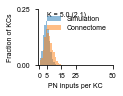

Figure saved at: C:\Users\Peter\PycharmProjects\olfaction_evolution\_hemibrain\figures\model_vs_hemibrain_weight


In [28]:
fig = plt.figure(figsize=FIGSIZE)
ax = fig.add_axes(RECT)

_plot_sparsity(ax, model_k, text=True, label='Simulation')
_plot_sparsity(ax, hemibrain_k, text=False, label='Connectome')
plt.legend(frameon=False)
save_fig(figure_path, 'model_vs_hemibrain_weight')

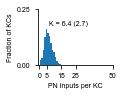

Figure saved at: C:\Users\Peter\PycharmProjects\olfaction_evolution\_hemibrain\figures\hemibrain_weight


In [33]:
fig = plt.figure(figsize=FIGSIZE)
ax = fig.add_axes(RECT)

_plot_sparsity(ax, hemibrain_k, text=True, label='Connectome', alpha=1)
save_fig(figure_path, 'hemibrain_weight')

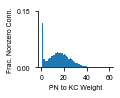

Figure saved at: C:\Users\Peter\PycharmProjects\olfaction_evolution\_hemibrain\figures\PN2KC_weight


In [30]:
f, ax = pretty_fig(figsize=FIGSIZE, rect=RECT)
plt.hist(hemibrain_weights, range=[0, 60], bins=60, density=True)
plt.xticks(np.arange(0, 61, 20));
plt.xlabel('PN to KC Weight')
plt.ylabel('Frac. Nonzero Conn.')
plt.yticks([0, 0.15])
plt.ylim([0, 0.15])

save_fig(figure_path, 'PN2KC_weight')



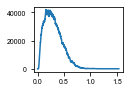

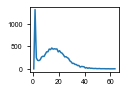

In [9]:
# def _plot_xy(xs, ys):
#     xs = [(x[1:] + x[:-1]) / 2 for x in xs]
#     new_ys = []
#     for i in range(len(xs)):
#         x = xs[i]
#         y = ys[i]
#         # Plot density by dividing by binsize
#         bin_size = x[1] - x[0]  # must have equal bin size
#         y = y / bin_size
#         if res['kc_prune_weak_weights'][i]:
#             y[0] = 0  # Ignore the pruned ones
#         # Smoothing
#         window_lenth = int(0.02 / bin_size / 2) * 2 + 1
#         y = savgol_filter(
#             y, window_length=window_lenth, polyorder=0)
#         new_ys.append(y)
#         ys = new_ys

def _xy_process(w, xs=None, filter=True):
    from scipy.signal import savgol_filter
    if xs is None:
        xs = np.linspace(0, np.max(w)*1.01, 1001)
    ys, _ = np.histogram(w.flatten(), bins=xs)
    xs = (xs[1:] + xs[:-1]) / 2
    bin_size = xs[1] - xs[0]  # must have equal bin size

    ys[0] = 0
    ys = ys / bin_size
    window_length = int(0.02 / bin_size / 2) * 2 + 1
    ys = savgol_filter(ys, window_length=window_length, polyorder=0)
    return xs, ys

plt.figure(figsize=FIGSIZE)
xs, ys = _xy_process(model_weights)
plt.plot(xs, ys)

plt.figure(figsize=FIGSIZE)
m = np.max(hemibrain_weights)
xs_, ys_ = _xy_process(hemibrain_weights, np.arange(0, m))
plt.plot(xs_, ys_)